### TF Differentiation of Ipsen upper bound formula

Testing numerically: Is the matrix-vector multiplication norm a convex function? Or a concave function? Or indefinite?

In [2]:
import numpy as np
np.set_printoptions(linewidth = 150, precision = 4, suppress = True)

In [13]:
data = np.loadtxt('../NC-Data.csv', delimiter=',', dtype=str)
data = data[1:].astype(np.float64)
# Only take 10 columns for testing.
np.random.seed(4)
def sample_hermitian(mat, choices):
    return mat[:, choices][choices, :]
data = sample_hermitian(data, np.random.choice(data.shape[0], 10))
# Synthesize columns holding observations, reproducing the cov matrix.
raw_data = np.linalg.cholesky(data).T
np.testing.assert_allclose(data, raw_data.T @ raw_data)
data

array([[ 1.    , -0.3093, -0.593 ,  0.2698,  0.0679,  0.349 , -0.7985, -0.1988, -0.0798, -0.0217],
       [-0.3093,  1.    ,  0.3678,  0.1036,  0.0957, -0.0789,  0.3371, -0.2643,  0.485 , -0.384 ],
       [-0.593 ,  0.3678,  1.    , -0.3317,  0.102 , -0.3785,  0.4811,  0.2561,  0.3855, -0.1261],
       [ 0.2698,  0.1036, -0.3317,  1.    ,  0.248 ,  0.2302,  0.0207, -0.6127,  0.2957, -0.1031],
       [ 0.0679,  0.0957,  0.102 ,  0.248 ,  1.    , -0.0462,  0.0432, -0.215 ,  0.495 , -0.1981],
       [ 0.349 , -0.0789, -0.3785,  0.2302, -0.0462,  1.    , -0.2407, -0.278 ,  0.0893,  0.156 ],
       [-0.7985,  0.3371,  0.4811,  0.0207,  0.0432, -0.2407,  1.    ,  0.0096,  0.2185,  0.077 ],
       [-0.1988, -0.2643,  0.2561, -0.6127, -0.215 , -0.278 ,  0.0096,  1.    , -0.2101,  0.373 ],
       [-0.0798,  0.485 ,  0.3855,  0.2957,  0.495 ,  0.0893,  0.2185, -0.2101,  1.    , -0.1276],
       [-0.0217, -0.384 , -0.1261, -0.1031, -0.1981,  0.156 ,  0.077 ,  0.373 , -0.1276,  1.    ]])

In [14]:
selected = np.asarray([0, 1])
U = np.linalg.svd(raw_data[:, selected], full_matrices=0)[0][:, 0]
XU = raw_data.T @ U
raw_data_residual = raw_data - U[:, None] * XU.T
sigma_residual = raw_data_residual.T @ raw_data_residual

In [15]:
import tensorflow as tf

In [45]:
@tf.function
def ipsen_nonlinear(sigma_residual, v, S):
    return tf.norm(tf.linalg.matmul(sigma_residual, S * v * tf.transpose(v))) / tf.math.sqrt(tf.math.reduce_sum(S * v * tf.transpose(v)))

In [46]:
ipsen_nonlinear(tf.constant(sigma_residual, tf.float64), tf.constant(XU, tf.float64), tf.cast(tf.eye(10), tf.float64))

<tf.Tensor: shape=(), dtype=float64, numpy=0.5189487576443317>

In [47]:
@tf.function
def ipsen_nonlinear_hessian(sigma_residual, v, S):
    return tf.hessians(ipsen_nonlinear(sigma_residual, v, S), S)

In [50]:
h = ipsen_nonlinear_hessian(tf.constant(sigma_residual, tf.float64), tf.constant(XU, tf.float64), tf.cast(tf.eye(10), tf.float64))[0].numpy()
h

array([[[[ 0.097 , -0.0745,  0.0154, ...,  0.    , -0.0017,  0.0009],
         [ 0.097 , -0.0745,  0.0154, ...,  0.    , -0.0017,  0.0009],
         [-0.0437,  0.0484, -0.029 , ...,  0.    ,  0.0005,  0.0003],
         ...,
         [-0.1257,  0.12  , -0.0293, ...,  0.    ,  0.0054, -0.0004],
         [ 0.0943, -0.0722, -0.001 , ...,  0.    , -0.0062,  0.0008],
         [-0.0876,  0.0867, -0.0045, ...,  0.    ,  0.0031, -0.0007]],

        [[-0.0745,  0.097 ,  0.0154, ...,  0.    , -0.0017,  0.0009],
         [-0.0745,  0.097 ,  0.0154, ...,  0.    , -0.0017,  0.0009],
         [ 0.0484, -0.0437, -0.029 , ...,  0.    ,  0.0005,  0.0003],
         ...,
         [ 0.12  , -0.1257, -0.0293, ...,  0.    ,  0.0054, -0.0004],
         [-0.0722,  0.0943, -0.001 , ...,  0.    , -0.0062,  0.0008],
         [ 0.0867, -0.0876, -0.0045, ...,  0.    ,  0.0031, -0.0007]],

        [[ 0.0154,  0.0154,  0.0606, ...,  0.    ,  0.0034,  0.0015],
         [ 0.0154,  0.0154,  0.0606, ...,  0.    ,  0.0034

In [51]:
import seaborn

<AxesSubplot:ylabel='Density'>

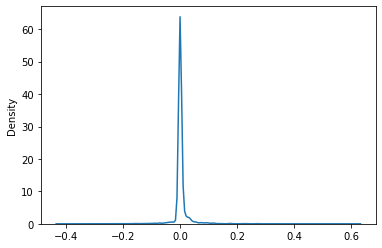

In [52]:
seaborn.kdeplot(h.flatten())